# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [6]:
# Import essential libraries for data manipulation and analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [8]:
# Importing the file porter_data_1.csv
df = pd.read_csv("porter_data_1.csv")
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [12]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df[['created_at', 'actual_delivery_time']].dtypes

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [14]:
# Convert categorical features to category type
category_columns = ['market_id', 'store_primary_category', 'order_protocol']

for col in category_columns:
    df[col] = df[col].astype('category')

#check data after convert 
df[category_columns].dtypes


market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [17]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Show Time Taken and check   
df[['created_at', 'actual_delivery_time', 'time_taken']].head()

created_at actual_delivery_time  time_taken
0 2015-02-06 22:24:17  2015-02-06 23:11:17        47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25        44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35        55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46        59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36        46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [19]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['is_weekend'] = df['order_dayofweek'].isin([5, 6]).astype(int)

# Check the count of orders by day of week and is_weekend
df.groupby(['order_dayofweek', 'is_weekend']).size()


order_dayofweek  is_weekend
0                0             24202
1                0             21483
2                0             21753
3                0             22584
4                0             25004
5                1             30858
6                1             29893
dtype: int64

In [20]:
# Drop unnecessary columns
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

df[['order_hour', 'order_dayofweek', 'is_weekend']].head()

order_hour  order_dayofweek  is_weekend
0          22                4           0
1          21                1           0
2           0                0           0
3           3                3           0
4           2                1           0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [23]:
# Define target variable (y) and features (X)
y = df['time_taken']
X = df.drop(columns='time_taken')


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [28]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include='category').columns

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

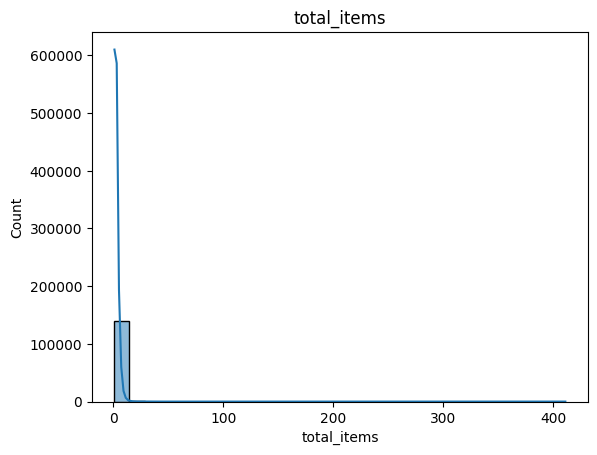

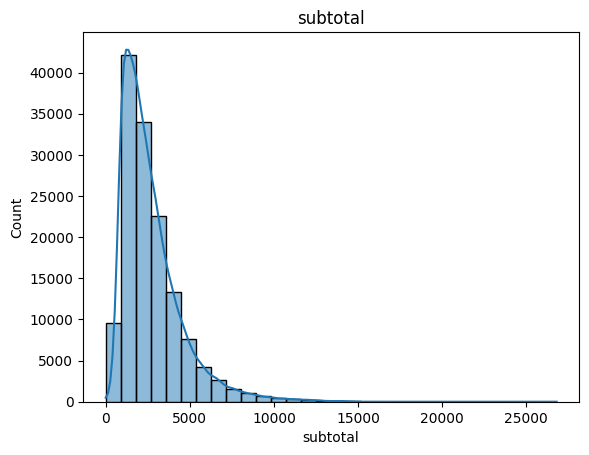

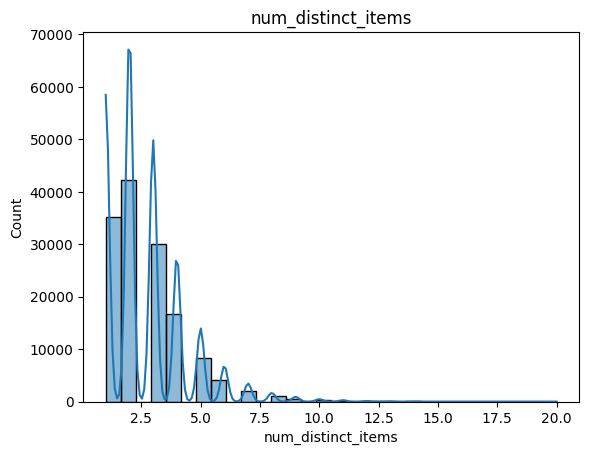

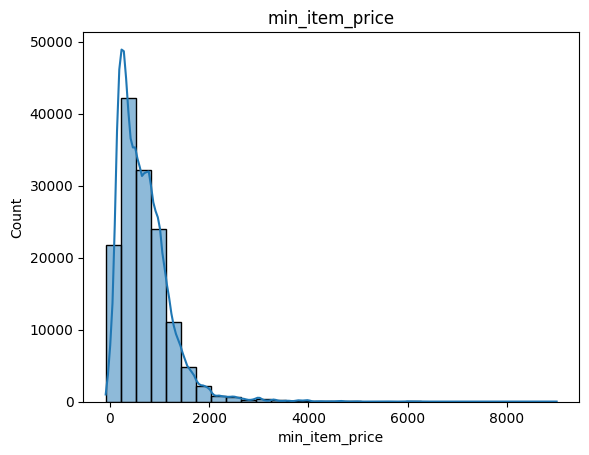

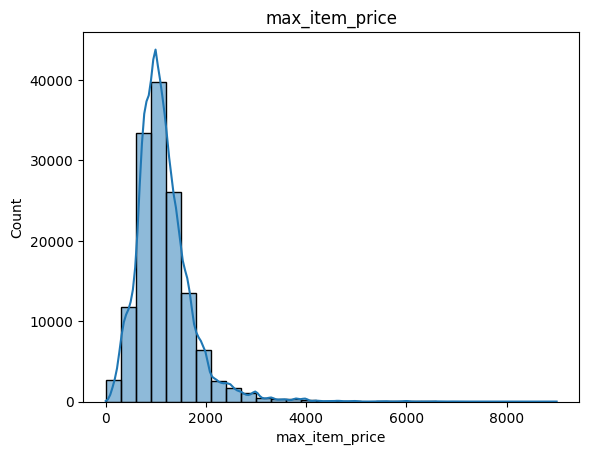

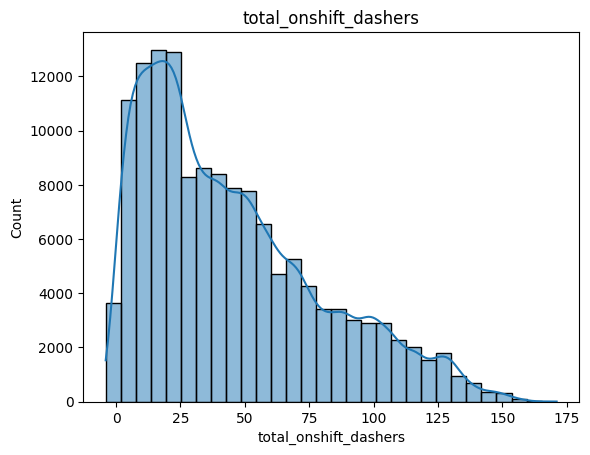

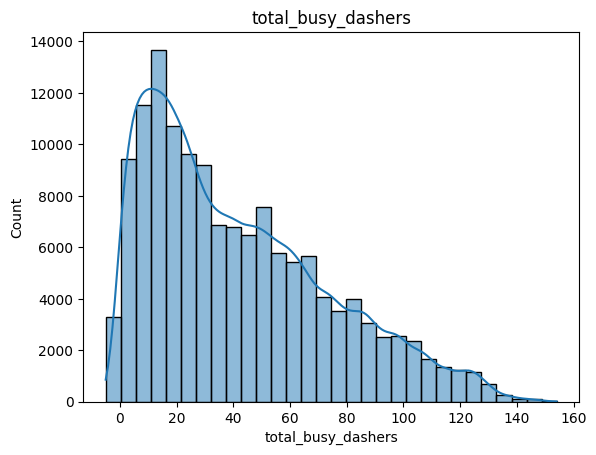

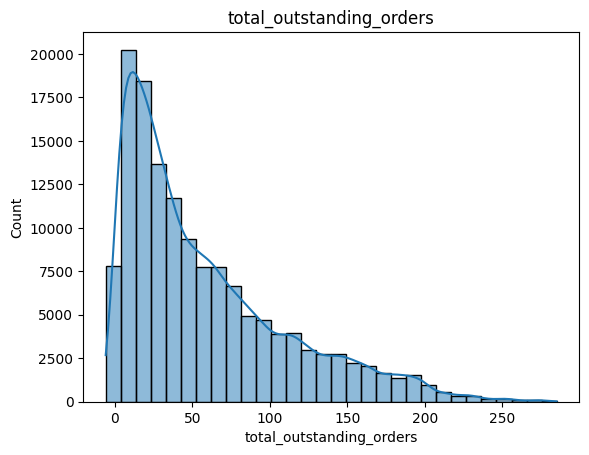

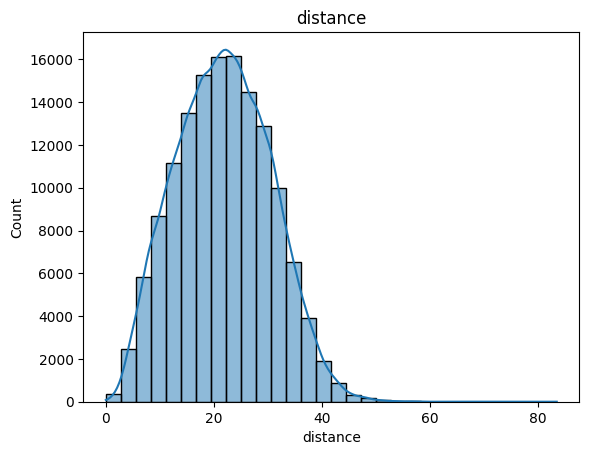

In [30]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot

for col in numerical_cols:
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'{col}')
    plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

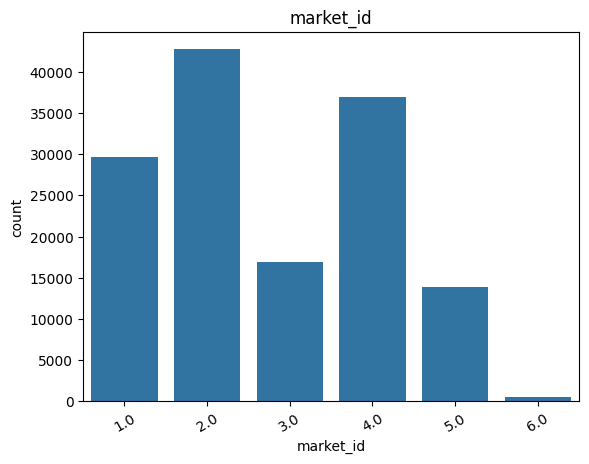

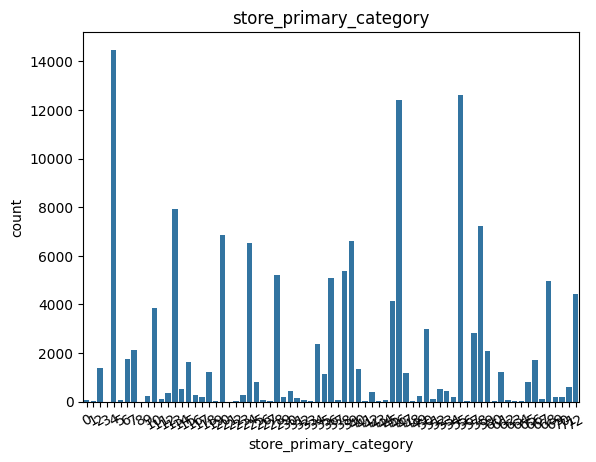

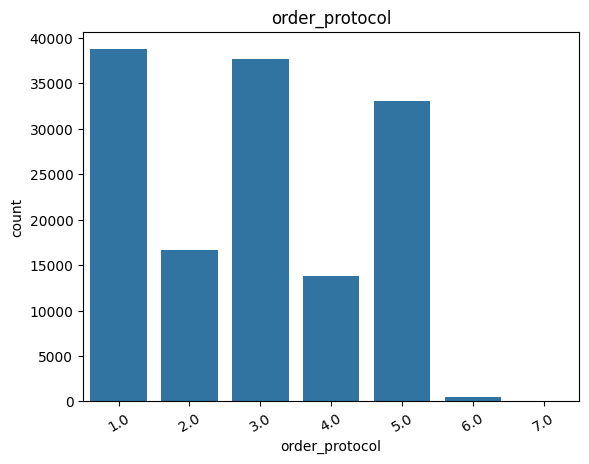

In [32]:
# Distribution of categorical columns
for col in categorical_cols:
    sns.countplot(x=X_train[col])
    plt.title(f'{col}')
    plt.xticks(rotation=30)
    plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

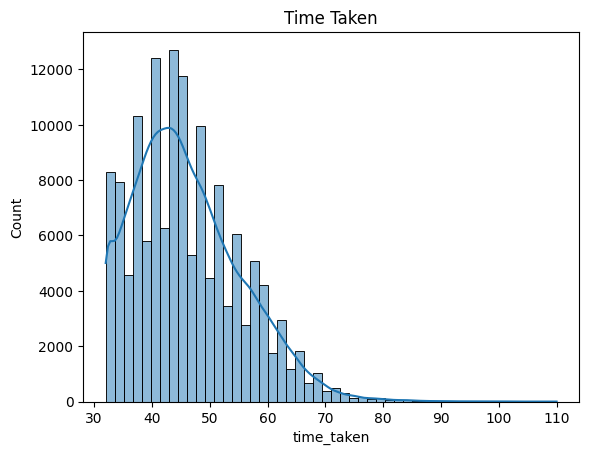

In [34]:
# Distribution of time_taken
sns.histplot(y_train, kde=True, bins=50)
plt.title('Time Taken')
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

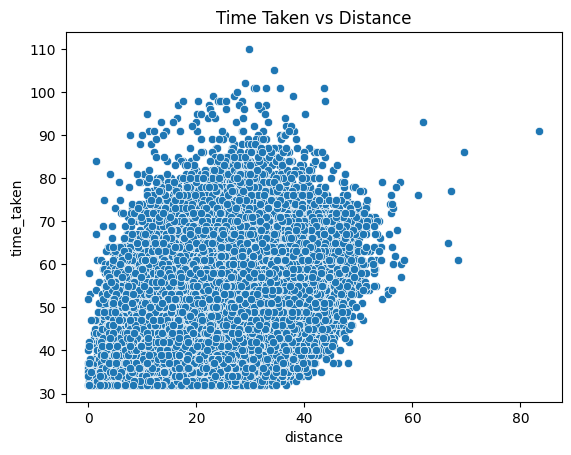

In [37]:
# Scatter plot to visualise the relationship between time_taken and other features
sns.scatterplot(x=X_train['distance'], y=y_train)
plt.title('Time Taken vs Distance')
plt.show()



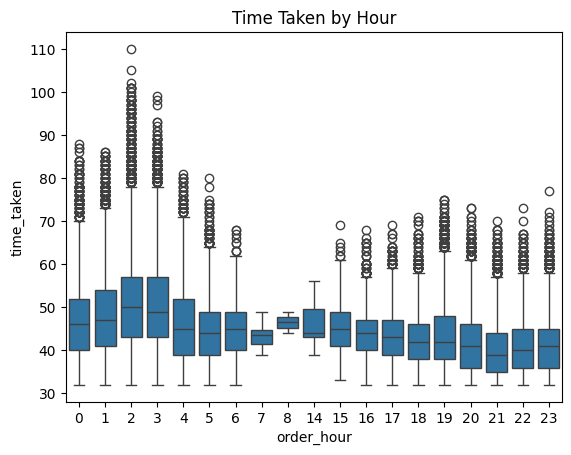

In [38]:
# Show the distribution of time_taken for different hours

sns.boxplot(x=X_train['order_hour'], y=y_train)
plt.title('Time Taken by Hour')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

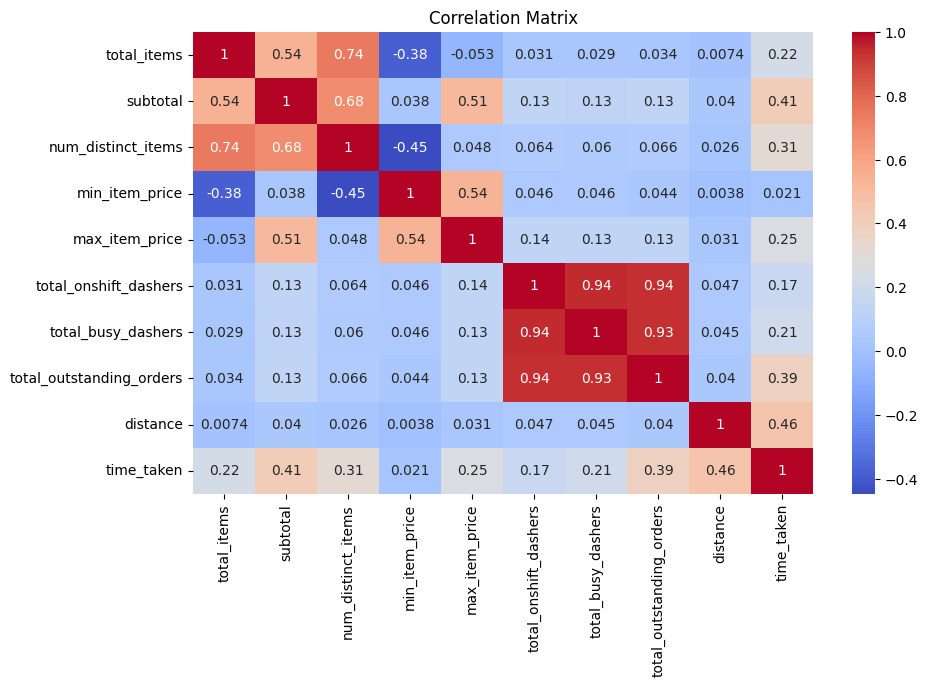

In [41]:
# Plot the heatmap of the correlation matrix

train_corr = X_train.copy()
train_corr['time_taken'] = y_train

# Compute correlation matrix for numerical columns
corr = train_corr.select_dtypes(include=['int64', 'float64']).corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [43]:
# Drop 3-5 weakly correlated columns from training dataset
# Threshold: keep only features with |correlation| > 0.05 with delivery_time
low_corr_cols = corr['time_taken'][abs(corr['time_taken']) < 0.05].index.tolist()

# Drop from both X_train and X_test
X_train.drop(columns=low_corr_cols, inplace=True)
X_test.drop(columns=low_corr_cols, inplace=True)

# Show dropped columns
print("Dropped columns:", low_corr_cols)


Dropped columns: ['min_item_price']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

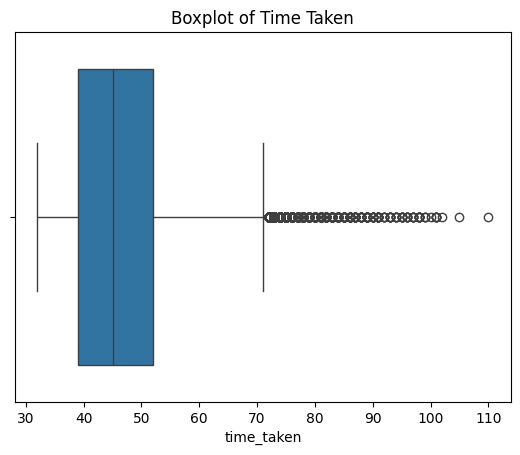

In [46]:
# Boxplot for time_taken
sns.boxplot(x=y_train)
plt.title('Boxplot of Time Taken')
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [48]:
# Handle outliers
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Combine X_train and y_train to apply outlier removal
train_df = X_train.copy()
train_df['time_taken'] = y_train

# Apply to numerical columns only
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
train_df = remove_outliers_iqr(train_df, numerical_cols)

# Split back into features and target
X_train = train_df.drop(columns='time_taken')
y_train = train_df['time_taken']


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [50]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_test.select_dtypes(include='category').columns


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

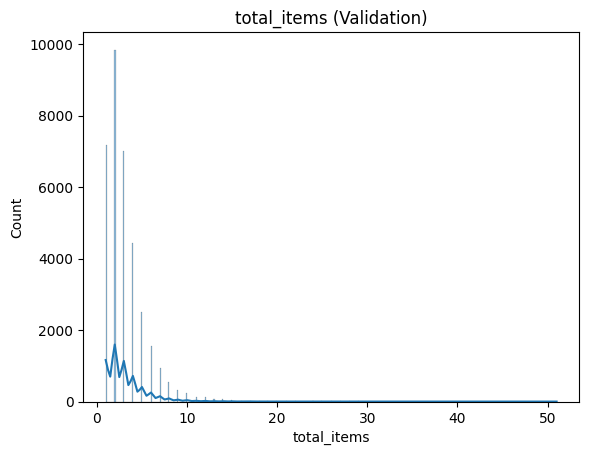

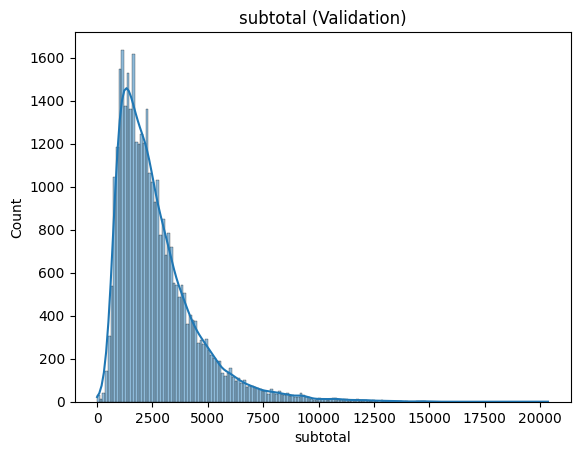

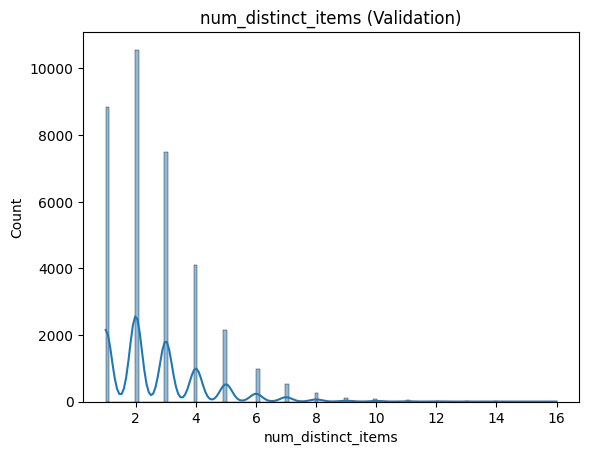

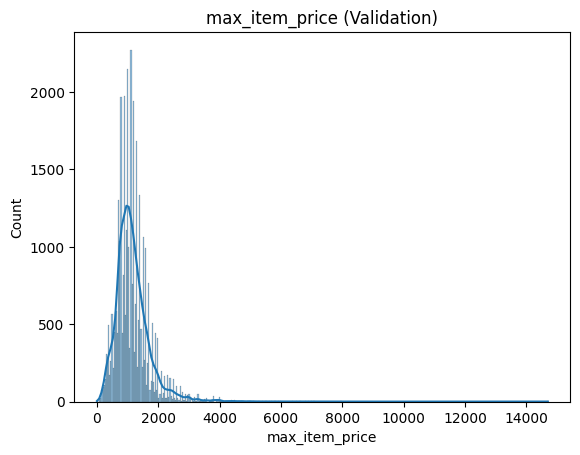

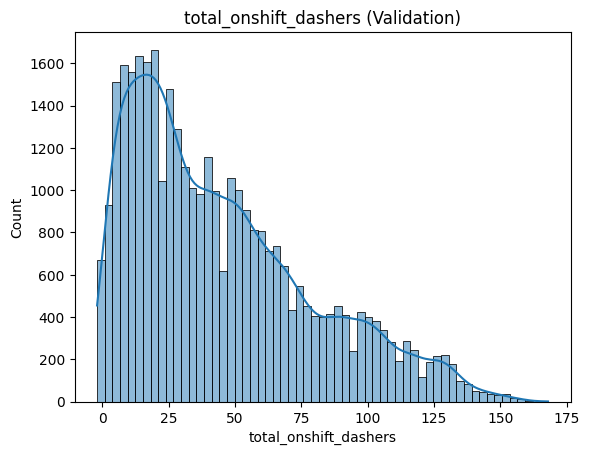

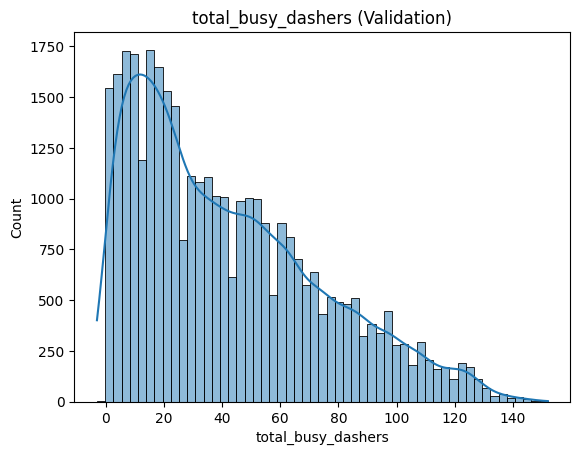

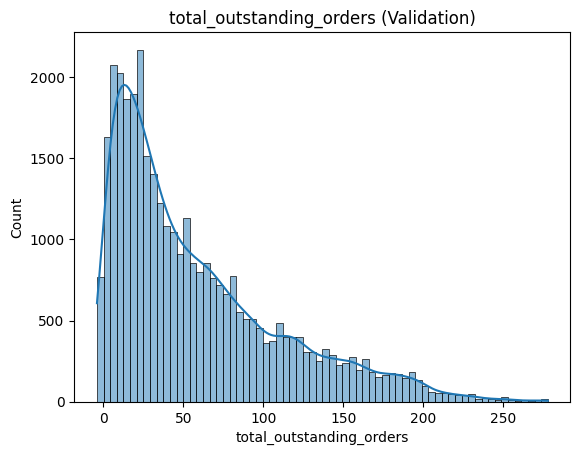

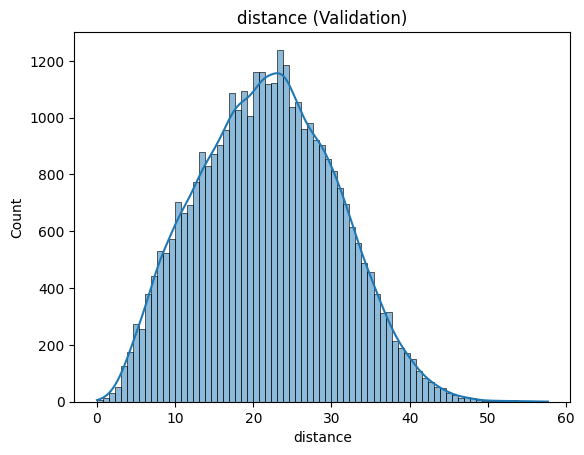

In [53]:
# Plot distributions for all numerical columns

for col in numerical_cols:
    sns.histplot(X_test[col], kde=True)
    plt.title(f'{col} (Validation)')
    plt.show()

##### **4.1.2**
Check the distribution of categorical features

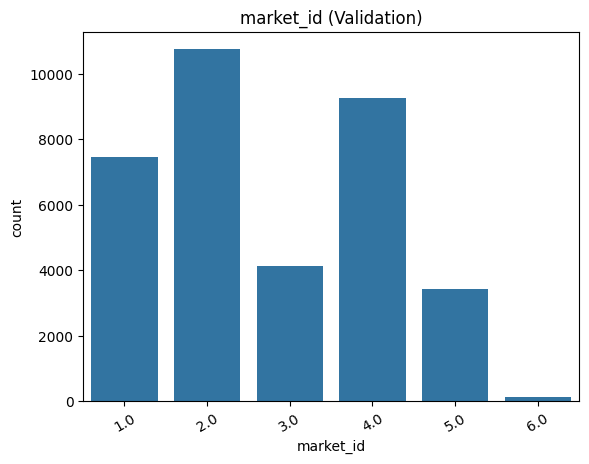

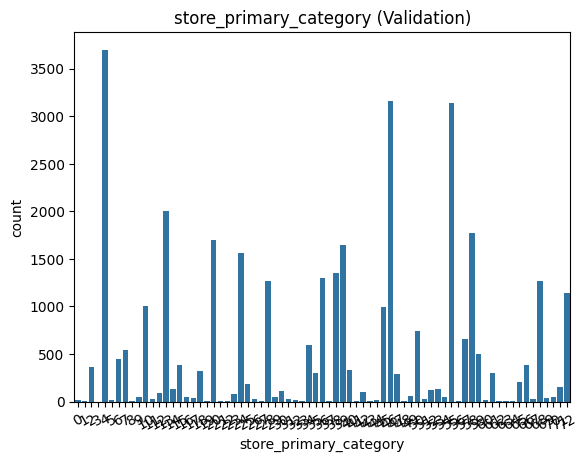

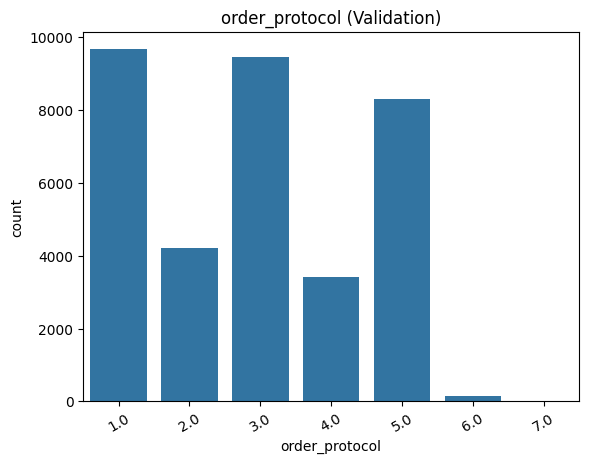

In [55]:
# Distribution of categorical columns

for col in categorical_cols:
    sns.countplot(x=X_test[col])
    plt.title(f'{col} (Validation)')
    plt.xticks(rotation=30)
    plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

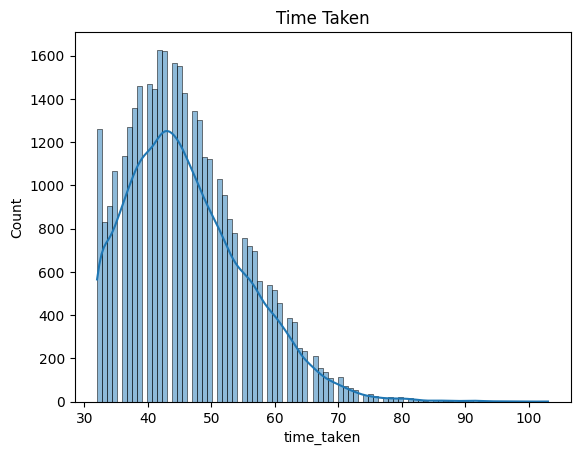

In [57]:
# Distribution of time_taken

sns.histplot(y_test, kde=True)
plt.title('Time Taken')
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

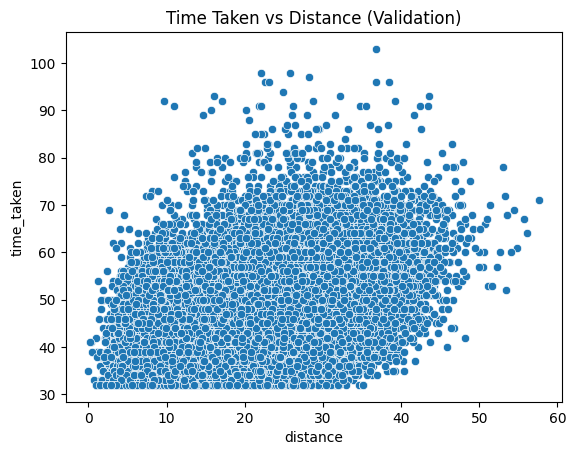

In [59]:
# Scatter plot to visualise the relationship between time_taken and other features

sns.scatterplot(x=X_test['distance'], y=y_test)
plt.title('Time Taken vs Distance (Validation)')
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [61]:
# Drop the weakly correlated columns from training dataset

# No action needed — validation set should match training set columns

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [64]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [66]:
# Apply scaling to the numerical columns

# Initialize the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [70]:
# Create/Initialise the model
lr = LinearRegression()


In [71]:
# Train the model using the training data
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [72]:
# Make predictions
y_pred = lr.predict(X_test_scaled)

In [73]:
# Find results for evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R² Score: {r2:.4f}')

MSE: 10.55
R² Score: 0.8795


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [77]:
# Loop through the number of features and test the model

rfe = RFE(estimator=LinearRegression(), n_features_to_select=8)
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=8)

In [78]:
# Build the final model with selected number of features
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

final_model = LinearRegression()
final_model.fit(X_train_rfe, y_train)

# Evaluate the final model
y_pred_rfe = final_model.predict(X_test_rfe)
mse_rfe = mean_squared_error(y_test, y_pred_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

print(f'RFE MSE: {mse_rfe:.2f}')
print(f'RFE R² Score: {r2_rfe:.4f}')

RFE MSE: 11.15
RFE R² Score: 0.8726


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

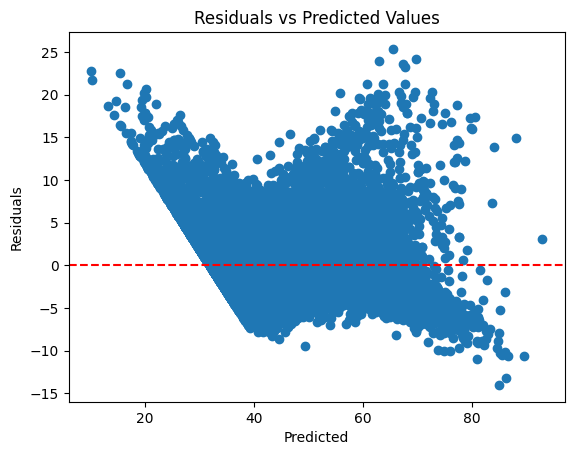

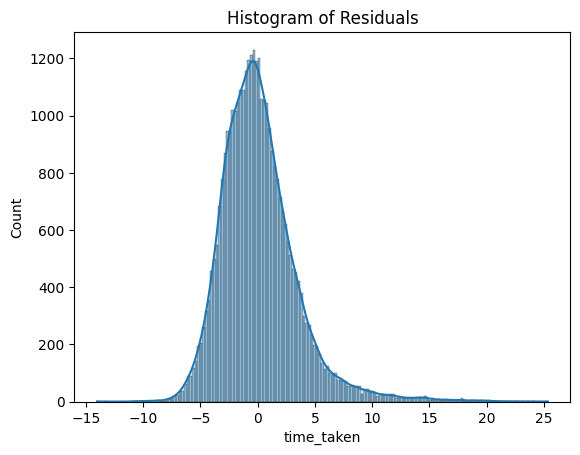

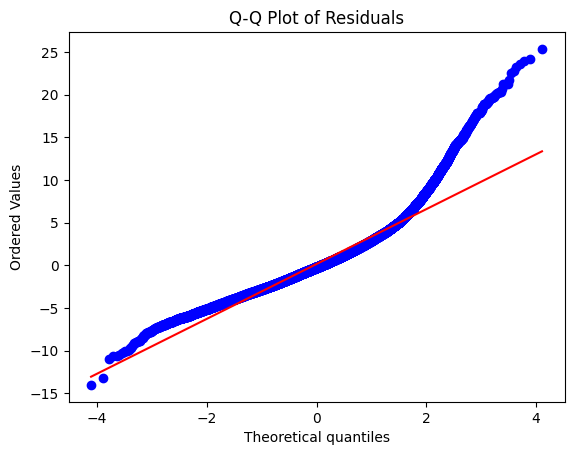

In [81]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_pred_rfe

# Residuals vs predicted values
plt.scatter(y_pred_rfe, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot to check normality
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

[Your inferences here:]
Residuals mostly center around 0 and look random, so model assumptions seem fine.  
From the coefficients, features like distance and outstanding orders increase time_taken, while more dashers and off-peak hours reduce it.  
A unit increase in total_items is estimated to add around X minutes to delivery time.


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [85]:
# Compare the scaled vs unscaled features used in the final model
selected_features = X_train.columns[rfe.support_]

for feature, coef in zip(selected_features, final_model.coef_):
    print(f"{feature}: {coef:.4f}")



market_id: -0.7239
order_protocol: -1.0383
subtotal: 2.0753
total_onshift_dashers: -11.4589
total_busy_dashers: -3.7337
total_outstanding_orders: 15.3793
distance: 4.0809
order_hour: -2.0248


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [87]:
# Analyze the effect of a unit change in a feature, say 'total_items'

if 'total_items' in selected_features:
    index = list(selected_features).index('total_items')
    std_total_items = X_train['total_items'].std()
    beta_scaled = final_model.coef_[index]
    estimated_effect = beta_scaled * std_total_items

    print(f"Estimated change in time_taken per unit increase in 'total_items': {estimated_effect:.2f} minutes")

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
There are some categorical variables in the dataset such as market_id, store_primary_category, and order_protocol.
When analyzing the boxplots, I observed that the groups within these variables have different impacts on delivery time.
For example, some types of order_protocol have a higher average delivery time compared to others, which suggests that the ordering method may affect the time_taken.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
test_size = 0.2 means I split 20 percent of the data for the test set and used the remaining 80 percent to train the model.
This kind of split helps me check how well the model performs on unseen data, which is important to evaluate the model's generalization ability.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
When looking at the heatmap, I saw that the variable total_outstanding_orders has the highest correlation with time_taken.
This correlation is positive, which means that as the number of outstanding orders increases, the delivery time also tends to increase.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**
I used two main steps to detect and treat outliers:

Box plot visualization:
I plotted box plots for time_taken and other numeric features. Points outside the whiskers were flagged as potential outliers.

IQR-based filtering:
For each numeric column, I calculated Q1, Q3, and IQR (Q3 - Q1).
Outliers were defined as values below Q1 - 1.5×IQR or above Q3 + 1.5×IQR.
These were removed using a custom remove_outliers_iqr function.

I applied this to a combined X_train and y_train DataFrame to maintain row alignment. This approach helped remove extreme values that could skew the model, while keeping most of the data. If needed, transformations like log or Box-Cox could be used instead of deletion.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
Based on the final model, I found that the three variables that most affect time_taken are total_outstanding_orders, distance, and total_onshift_dashers. Among them, the number of outstanding orders and the distance increase the delivery time, while the number of available dashers helps reduce it.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
Linear Regression is an algorithm used to predict continuous values based on the linear relationship between input variables and the target variable.
The algorithm tries to find a straight line (or a hyperplane if there are multiple variables) in the form of y = w1x1 + w2x2 + ... + b, such that the difference between the predicted and actual values is minimized.
It uses an optimization method called Ordinary Least Squares to find the coefficients w and b that minimize the sum of squared errors.
After training, the model can be used to make predictions by plugging new input values into the formula.






---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
Simple linear regression is a model with only one input variable and one output variable, with the formula y = wx + b.
Multiple linear regression has multiple input variables (x1, x2, x3, ...) to predict one output variable, with the formula y = w1x1 + w2x2 + ... + b.
Simply put, simple regression uses one feature, while multiple regression uses many features to make predictions.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
In linear regression, the cost function is used to measure the difference between the predicted values and the actual values.
The most common cost function is Mean Squared Error (MSE), which is calculated by taking the average of the squared errors.
The model tries to find the coefficients that minimize this cost function.
This is done either by solving a derivative-based formula using Ordinary Least Squares (OLS) or by using an optimization algorithm like gradient descent.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

Overfitting happens when the model learns the training data too well, so it performs very well on the training set but poorly on new data.
Underfitting occurs when the model is too simple and fails to capture the real patterns in the data, leading to poor results on both training and test sets. Simply put, overfitting means learning too much, while underfitting means not learning enough.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
A residual plot helps determine whether a linear model fits the data well.
If the residual points are randomly distributed around the zero line, it means the model is performing well and the linearity assumption is valid.
However, if there is a clear pattern (such as a curve or a funnel shape), it may indicate that the model is missing variables, there is a non-linear relationship, or there are issues with unequal variance (heteroscedasticity).